In [1]:
from joblib import load
import numpy as np
import pandas as pd
import spacy
import re
from fractions import Fraction
from decimal import Decimal, InvalidOperation
import unicodedata
import sys
sys.path.append("..")
from src.data import data_cleaning_util
from src.features import create_features
import unidecode
from collections import Counter
import operator
%pprint

Pretty printing has been turned OFF


In [2]:
# Load our trained CRF model and the spacy NLP Model
crf = load('../models/crf_model.joblib')
nlp = spacy.load('en_core_web_lg', disable=['ner','textcat'])

In [3]:
epi_raw = pd.read_json("../data/raw/recipes_raw_epi.json")
se_raw = pd.read_json("../data/raw/recipes_raw_se.json")

In [4]:
# We need to transpose the matrix so that we have a the recipes as rows and ingredients as columns
epi_data = epi_raw.transpose()
se_data = se_raw.transpose()

# Select a subset so processing happend faster
#epi_data = epi_data.head(1000)
#se_data = se_data.head(1000)
#epi_data.head()
#se_data.head()

In [5]:
# Drop rows with empty ingredients
num_rows = epi_data.shape[0]
epi_data = epi_data[epi_data.astype(str)['ingredients'] != '[]']
epi_data.dropna(axis=0, subset=["ingredients"], inplace=True)
print("Dropped {} rows with no ingredients".format(num_rows - epi_data.shape[0]))

num_rows = se_data.shape[0]
se_data = se_data[se_data.astype(str)['ingredients'] != '[]']
se_data.dropna(axis=0, subset=["ingredients"], inplace=True)
print("Dropped {} rows with no ingredients".format(num_rows - se_data.shape[0]))

Dropped 102 rows with no ingredients
Dropped 238 rows with no ingredients


In [6]:
epi_data = pd.concat([epi_data, se_data])
epi_data.shape

(49034, 11)

In [7]:
# We do two things next, we create a new dataframe to contain all the ingredient info
# and rearrange it so that it has one ingredient per row. All the non-ingredient columns
# are kept in the original dataframe.
ingredients = epi_data['ingredients'].apply(pd.Series, 1).stack()
ingredients.index = ingredients.index.droplevel(-1)
ingredients.name = 'input'
epi_ingredients = epi_data.join(ingredients)
epi_ingredients.head()

,avg_rating,best_rating,ingredients,instructions,num_reviews,prepare_again_rating,tags,title,total_time,worst_rating,yields,input
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),2 or 3 large garlic cloves
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),a 2-ounce jar diced pimientos
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),3 cups coarsely grated sharp Cheddar (preferab...
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),1/3 to 1/2 cup mayonnaise
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,"[2 or 3 large garlic cloves, a 2-ounce jar dic...",Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0,2 item(s),crackers


In [8]:
# Drop non ingredient/yield columns from ingredient dataframe
epi_ingredients = epi_ingredients[["input","yields"]]
epi_ingredients.head()

,input,yields
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2 or 3 large garlic cloves,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,a 2-ounce jar diced pimientos,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,3 cups coarsely grated sharp Cheddar (preferab...,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,1/3 to 1/2 cup mayonnaise,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,crackers,2 item(s)


In [9]:
 # Drop ingredient/yield columns from data dataframe
del epi_data["ingredients"]
del epi_data["yields"]
epi_data.head()

,avg_rating,best_rating,instructions,num_reviews,prepare_again_rating,tags,title,total_time,worst_rating
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4,Force garlic through a garlic press into a lar...,25,0.85,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",0,0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,3.5,4,Melt butter in a large heavy skillet over medi...,3,0.67,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",0,0
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,3,4,Place eggplants on double thickness of paper t...,4,0.75,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant",0,0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,4,4,"Combine lemon zest, lemon juice, shallot, toma...",2,1,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor...",0,0
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,3.5,4,Cut zucchini crosswise into 1/8-inch-thick sli...,48,0.93,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini",0,0


In [10]:
def clean_epi_html(ingredient):
    # this will remove all: epi:recipelink stuff
    match = re.findall(r'[<>\/\"\\\=]*[epi]+[\:\s]recipe[lL]ink.*?[><\/]', ingredient)
    if match:
        for m in match:
            ingredient = re.sub(r'[<>\/\"\\\=]*[epi]+[\:\s]recipe[lL]ink.*?[><\/]', "", ingredient)
    match = re.findall(r'<\/?[a-zA-Z]+>', ingredient)
    if match:
        for m in match:
            ingredient = re.sub(r'<\/?[a-zA-Z\s\"\\]+>', "", ingredient)
    match = re.findall(r">[A-Z]<", ingredient)
    if match:
        for m in match:
            ingredient = re.sub(r">[A-Z]<", "", ingredient)
    match = re.findall(r">\/[A-Z]", ingredient)
    if match:
        for m in match:
            ingredient = re.sub(r">\/[A-Z]", "", ingredient)
    match = re.findall(r"\=[\\\"]+", ingredient)
    if match:
        for m in match:
            ingredient = re.sub(r"\=[\\\"]+", "", ingredient)
    match = re.findall(r"\\n", ingredient)
    if match:
        for m in match:
            ingredient = re.sub(r"\\n", " ", ingredient)
    # this will remove all un-escapped '\t' from the original html
    match = re.findall(r"\\t", ingredient)
    if match:
        for m in match:
            ingredient = re.sub(r"\\t", " ", ingredient)
    # if the column is now blank becasue of what we removed, set it
    # to NaN so pandas can handle it easier
    if not ingredient:
        ingredient = ""
    else:
        ingredient = ingredient.strip()
    return ingredient

In [11]:
epi_ingredients["input"] = epi_ingredients["input"].apply(clean_epi_html)


In [12]:
# Drop rows that have no input
print(epi_ingredients.shape)
epi_ingredients.dropna(axis=0, subset=["input"], inplace=True)
print(epi_ingredients.shape)
#epi_ingredients["input"] = epi_ingredients["input"].apply(data_cleaning_util.fix_characters)

(493086, 2)
(493086, 2)


In [13]:
epi_ingredients.to_csv("../data/interim/epi_partial_clean.csv")

In [15]:
c = Counter()

epi_ingredients["input"].apply(lambda x: c.update(list(str(x))))

# We expect alphabet, digit, and punctuation characters so lets remove them
for i in list(c):
    if i.isalpha() or i.isdigit():
        del c[i] 
sorted(c.keys())

[' ', '"', '#', '$', '%', "'", '(', ')', ',', '-', '.', '/', ':', ';', '<', '=', '>', '_', '{', '}', '~', '\xad', '°', '·', '¼', '½', '¾', '¿', '˚', '̀', '́', '̂', '̃', '\u200b', '‐', '‑', '–', '—', '‚', '…', '‧', '⅓', '⅔', '⅛', '⅞', '−', '\uf0b0']

In [14]:
epi_ingredients["input"] = epi_ingredients["input"].apply(data_cleaning_util.fix_characters)

In [16]:
epi_ingredients.head(25)

,input,yields
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2 or 3 large garlic cloves,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,a 2-ounce jar diced pimientos,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,3 cups coarsely grated sharp Cheddar (preferab...,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,1/3 to 1/2 cup mayonnaise,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,crackers,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,toasted baguette slices,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,crudités,2 item(s)
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,1/4 cup (1/2 stick) unsalted butter,6 item(s)
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,4-5 medium apples (such as Honeycrisp; about 2...,6 item(s)
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,1/2 cup (packed) light brown sugar,6 item(s)


In [17]:

        
def process_data(input_data):
    # Remove random HTML tags
    
    input_data["input"] = input_data["input"].apply(data_cleaning_util.fix_spelling)
    
    
    

    # Drop rows that have no input
    print(input_data.shape)
    input_data['input'].replace('', np.nan, inplace=True)
    input_data.dropna(axis=0, subset=["input"], inplace=True)
    print(input_data.shape)

    input_data["input"] = input_data["input"].apply(data_cleaning_util.fix_abbreviations)
    input_data["input"] = input_data["input"].apply(data_cleaning_util.fix_numeric_words)
    # Unicode has numerous characters to represent fractions like ¾, we remove these
    input_data["input"] = input_data["input"].apply(data_cleaning_util.clean_unicode_fractions)
    input_data["input"] = input_data["input"].apply(str).apply(unidecode.unidecode)

    # Many ingredient quantities are written as 1 1/2 to represent 1.5
    # The quantity label however is always written as 1.5 so we need to
    # convert these fractions so that the crf can match it
    input_data["input"] = input_data["input"].apply(data_cleaning_util.merge_fractions)

    input_data["input"] = input_data["input"].apply(data_cleaning_util.merge_quantities)
    #input_data["input"] = input_data["input"].apply(data_cleaning_util.fix_measurements(nlp=nlp))

    return input_data

In [18]:
# Clean the ingredients
epi_ingredients = process_data(epi_ingredients)
epi_ingredients.head(25)

(493086, 2)
(491177, 2)


,input,yields
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5 large garlic cloves,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,a 2 ounce jar diced pimientos,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,3 cups coarsely grated sharp Cheddar (preferab...,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.42 cup mayonnaise,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,crackers,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,toasted baguette slices,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,crudites,2 item(s)
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.25 cup (0.5 stick) unsalted butter,6 item(s)
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,4.5 medium apples (such as Honeycrisp; about 2...,6 item(s)
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.5 cup (packed) light brown sugar,6 item(s)


In [20]:
epi_clean = epi_ingredients.copy()
measurementUnit = ['teaspoon', 'tablespoon', 'cup', 'milliliter', 'gram', 'container', 'packet', 'bag', 'quart', 'pound', 'can', 'bottle',
                   'pint', 'package', 'ounce', 'jar', 'head', 'gallon', 'drop', 'envelope', 'bar', 'box', 'pinch',
                   'dash', 'bunch', 'recipe', 'layer', 'slice', 'link', 'bulb', 'stalk', 'square', 'sprig', 'fillet',
                   'piece', 'leg', 'thigh', 'cube', 'granule', 'strip', 'tray', 'leave', 'loaf', 'halve','clove',
                   'cleave','leaf','leave','stick']
def fix_measurements(string):
    
    if "plus" in string or "and" in string:
        input_tokens = nlp(string)
        lemmatized_input = " ".join([x.lemma_ for x in input_tokens])


        match = re.findall(
            r"(\d+\.?\d*) (\w+) (plus|and) (\d+\.?\d*) (\w+)", lemmatized_input
        )
        for m in match:
            if m[1] in measurementUnit and m[4] in measurementUnit:
                num = 0
                unit = ""
                # sticks and tablespoons of butter
                if (
                    m[1] == "stick"
                    and m[4] == "tablespoon"
                    and "butter" in lemmatized_input
                ):
                    num += float(m[0]) * 113.398
                    num += float(m[3]) * 14.18
                    unit = "gram"
                elif (
                    m[1] == "tablespoon"
                    and m[4] == "stick"
                    and "butter" in lemmatized_input
                ):
                    num += float(m[0]) * 14.28
                    num += float(m[3]) * 113.398
                    unit = "gram"
                elif (
                    m[1] == "pound"
                    and m[4] == "tablespoon"
                    and "butter" in lemmatized_input
                ):
                    num += float(m[0]) * 453.592
                    num += float(m[3]) * 14.18
                    unit = "gram"
                elif (
                    m[1] == "ounce"
                    and m[4] == "tablespoon"
                    and "butter" in lemmatized_input
                ):
                    num += float(m[0]) * 28.3495
                    num += float(m[3]) * 14.18
                    unit = "gram"
                elif m[1] == "pound" and m[4] == "ounce":
                    num += float(m[0]) * 453.592
                    num += float(m[3]) * 28.3495
                    unit = "gram"
                elif m[1] == "head" and m[4] == "clove" and "garlic" in lemmatized_input:
                    num += float(m[0]) * 56.699
                    num += float(m[3]) * 5.15
                    unit = "gram"
                elif (
                    m[1] == "tablespoon"
                    and m[4] == "clove"
                    and "garlic" in lemmatized_input
                ):
                    num += float(m[0]) * (5.15 * 3)
                    num += float(m[3]) * 5.15
                    unit = "gram"
                elif (
                    m[1] == "packet"
                    and m[4] == "teaspoon"
                    and "gelatin" in lemmatized_input
                ):
                    num += float(m[0]) * 7
                    num += float(m[3]) * 3.08
                    unit = "gram"
                elif (
                    m[1] == "bunch"
                    and m[4] == "bunch"
                ):
                    num += float(m[0])
                    num += float(m[3])
                    unit = "bunch"
                elif (
                    m[1] == "gram"
                    and m[4] == "gram"
                ):
                    num += float(m[0])
                    num += float(m[3])
                    unit = "gram"
                else:
                    if m[1] == "teaspoon":
                        num += float(m[0]) * 4.92892
                    elif m[1] == "tablespoon":
                        num += float(m[0]) * 14.7868
                    elif m[1] == "ounce":
                        num += float(m[0]) * 29.5735
                    elif m[1] == "cup":
                        num += float(m[0]) * 236.588
                    elif m[1] == "quart":
                        num += float(m[0]) * 946.353
                    elif m[1] == "bottle" and "wine" in lemmatized_input:
                        num += float(m[0]) * 750
                    elif m[1] == "milliliter":
                        num += float(m[0])
                    else:
                        print(string)
                    if m[4] == "drop":
                        num += float(m[3]) * 0.05
                    elif m[4] == "teaspoon":
                        num += float(m[3]) * 4.92892
                    elif m[4] == "tablespoon":
                        num += float(m[3]) * 14.7868
                    elif m[4] == "ounce":
                        num += float(m[3]) * 29.5735
                    elif m[4] == "cup":
                        num += float(m[3]) * 236.588
                    elif m[4] == "quart":
                        num += float(m[3]) * 946.353
                    elif m[4] == "pinch":
                        num += float(m[3]) * 0.31
                    elif m[4] == "milliliter":
                        num += float(m[3])
                    else:
                        print(string)
                        print(lemmatized_input)
                    unit = "milliliter"
                string = re.sub(
                    r"^(\d+\.?\d*) (\w+) (plus|and) (\d+\.?\d*) (\w+)",
                    str(round(num, 2)) + " " + unit,
                    string,
                )
    return string
epi_clean["input"] = epi_clean["input"].apply(fix_measurements)
epi_clean.head()

1 envelope plus 0.75 teaspoon unflavored gelatin (about 3.25 teaspoons)
1 tablespoon unflavored gelatin (about 1 envelope plus 0.5 teaspoon)
1 envelope plus 1.5 teaspoons (about 4.5 teaspoons total) unflavored gelatin
128.15 milliliter (100 gram plus 10 gram) granulated sugar, plus more for pan
128.15 milliliter (100 gram plus 10 gram) granulated sugar, plus more for pan
0.5 cup plus 2 teaspoon ( 100 gram plus 10 gram ) granulated sugar , plus more for pan
1 envelope plus 1 teaspoon unflavored gelatin (about 1 tablespoon plus 0.25 teaspoon)
1.25 pounds dark turkey parts (1 leg and 1 thigh)
1.25 pounds dark turkey parts (1 leg and 1 thigh)
1.25 pound dark turkey part ( 1 leg and 1 thigh )
0.75 cup/150 gram plus 1 tablespoon granulated sugar, divided
1 pound plus 1 cup confectioners'' sugar (about 5 cups total)
1 cup confectioner's sugar, plus 0.5 cup more for coating (4.5 ounces plus 2.25 ounces for coating; 125 gram plus 65 gram for coating)
1 cup confectioner's sugar, plus 0.5 cup mor

,input,yields
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5 large garlic cloves,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,a 2 ounce jar diced pimientos,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,3 cups coarsely grated sharp Cheddar (preferab...,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.42 cup mayonnaise,2 item(s)
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,crackers,2 item(s)


In [21]:
def word2features(sent, i):
    

        

    features = {
        "bias": 1.0,
        "lemma": sent[i].lemma_,
        #"pos": sent[i].pos_,
        #"tag": sent[i].tag_,
        #"dep": sent[i].dep_,
        "shape": sent[i].shape_,
        "is_alpha": sent[i].is_alpha,
        "is_stop": sent[i].is_stop,
        "is_title": sent[i].is_title,
        "like_num": sent[i].like_num,
        "is_punct": sent[i].is_punct,
        "is_left_punct": sent[i].is_left_punct,
        "is_right_punct": sent[i].is_right_punct,
        
    }
    if i > 0:
        features.update(
            {
                "-1:lemma": sent[i - 1].lemma_,
                #"-1:pos": sent[i - 1].pos_,
                #"-1:tag": sent[i - 1].tag_,
                #"-1:dep": sent[i - 1].dep_,
                "-1:shape": sent[i - 1].shape_,
                "-1:is_alpha": sent[i - 1].is_alpha,
                "-1:is_stop": sent[i - 1].is_stop,
                "-1:is_title": sent[i - 1].is_title,
                "-1:like_num": sent[i - 1].like_num,
                "-1:is_punct": sent[i - 1].is_punct,
                "-1:is_left_punct": sent[i - 1].is_left_punct,
                "-1:is_right_punct": sent[i - 1].is_right_punct,
                "after_or": any([x.lemma_ == "or" for x in sent[:i]]),
                "parens": any([x.lemma_ == "(" for x in sent[:i]]) and not any([x.lemma_ == ")" for x in sent[:i]])
            }
        )
        if i > 1:
            features.update(
                {
                    "-2:lemma": sent[i - 2].lemma_,
                    #"-2:pos": sent[i - 2].pos_,
                    #"-2:tag": sent[i - 2].tag_,
                    #"-2:dep": sent[i - 2].dep_,
                    "-2:shape": sent[i - 2].shape_,
                    "-2:is_alpha": sent[i - 2].is_alpha,
                    "-2:is_stop": sent[i - 2].is_stop,
                    "-2:is_title": sent[i - 2].is_title,
                    "-2:like_num": sent[i - 2].like_num,
                    "-2:is_punct": sent[i - 2].is_punct,
                    "-2:is_left_punct": sent[i - 2].is_left_punct,
                    "-2:is_right_punct": sent[i - 2].is_right_punct,
                    "-1:after_or": any([x.lemma_ == "or" for x in sent[:i-1]]),
                    "-1:parens": any([x.lemma_ == "(" for x in sent[:i-1]]) and not any([x.lemma_ == ")" for x in sent[:i-1]])
                }
            )
            """if i > 2:
                features.update(
                    {
                        "-3:lemma": sent[i - 3].lemma_,
                        #"-2:pos": sent[i - 2].pos_,
                        #"-2:tag": sent[i - 2].tag_,
                        #"-2:dep": sent[i - 2].dep_,
                        "-3:shape": sent[i - 3].shape_,
                        "-3:is_alpha": sent[i - 3].is_alpha,
                        "-3:is_stop": sent[i - 3].is_stop,
                        "-3:is_title": sent[i - 3].is_title,
                        "-3:like_num": sent[i - 3].like_num,
                        "-3:is_punct": sent[i - 3].is_punct,
                        "-3:is_left_punct": sent[i - 3].is_left_punct,
                        "-3:is_right_punct": sent[i - 3].is_right_punct,
                    }
                )"""
    else:
        features["BOS"] = True

    if i < len(sent) - 1:
        features.update(
            {
                "+1:lemma": sent[i + 1].lemma_,
                #"+1:pos": sent[i + 1].pos_,
                #"+1:tag": sent[i + 1].tag_,
                #"+1:dep": sent[i + 1].dep_,
                "+1:shape": sent[i + 1].shape_,
                "+1:is_alpha": sent[i + 1].is_alpha,
                "+1:is_stop": sent[i + 1].is_stop,
                "+1:is_title": sent[i + 1].is_title,
                "+1:like_num": sent[i + 1].like_num,
                "+1:is_punct": sent[i + 1].is_punct,
                "+1:is_left_punct": sent[i + 1].is_left_punct,
                "+1:is_right_punct": sent[i + 1].is_right_punct,
                "+1:after_or": any([x.lemma_ == "or" for x in sent[:i+1]]),
                "+1:parens": any([x.lemma_ == "(" for x in sent[:i+1]]) and not any([x.lemma_ == ")" for x in sent[:i+1]])
            }
        )
        if i < len(sent) - 2:
            features.update(
                {
                    "+2:lemma": sent[i + 2].lemma_,
                    #"+2:pos": sent[i + 2].pos_,
                    #"+2:tag": sent[i + 2].tag_,
                    #"+2:dep": sent[i + 2].dep_,
                    "+2:shape": sent[i + 2].shape_,
                    "+2:is_alpha": sent[i + 2].is_alpha,
                    "+2:is_stop": sent[i + 2].is_stop,
                    "+2:is_title": sent[i + 2].is_title,
                    "+2:like_num": sent[i + 2].like_num,
                    "+2:is_punct": sent[i + 2].is_punct,
                    "+2:is_right_punct": sent[i + 2].is_left_punct,
                    "+2:is_right_punct": sent[i + 2].is_right_punct,
                    "+2:after_or": any([x.lemma_ == "or" for x in sent[:i+2]]),
                    "+2:parens": any([x.lemma_ == "(" for x in sent[:i+2]]) and not any([x.lemma_ == ")" for x in sent[:i+2]])
                }
            )
            """if i < len(sent) - 3:
                features.update(
                    {
                        "+3:lemma": sent[i + 3].lemma_,
                        #"+2:pos": sent[i + 2].pos_,
                        #"+2:tag": sent[i + 2].tag_,
                        #"+2:dep": sent[i + 2].dep_,
                        "+3:shape": sent[i + 2].shape_,
                        "+3:is_alpha": sent[i + 3].is_alpha,
                        "+3:is_stop": sent[i + 3].is_stop,
                        "+3:is_title": sent[i + 3].is_title,
                        "+3:like_num": sent[i + 3].like_num,
                        "+3:is_punct": sent[i + 3].is_punct,
                        "+3:is_right_punct": sent[i + 3].is_left_punct,
                        "+3:is_right_punct": sent[i + 3].is_right_punct,
                    }
                )"""
    else:
        features["EOS"] = True

    return features

In [22]:
epi_backup_1 = epi_clean.copy()
epi_ingredients = epi_backup_1.copy()

In [23]:
# have spacy parse the input string with the full pipeline to generate features this will take some time
epi_ingredients["input"] = list(
        nlp.pipe(epi_ingredients["input"].astype("unicode").values, batch_size=50)
    )


# Create our features dict
epi_ingredients["features"] = epi_ingredients["input"].apply(
    lambda doc: [word2features(doc, i) for i in range(len(doc))]
)
epi_ingredients.head(25)

,input,yields,features
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(2.5, large, garlic, cloves)",2 item(s),"[{'bias': 1.0, 'lemma': '2.5', 'shape': 'd.d',..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(a, 2, ounce, jar, diced, pimientos)",2 item(s),"[{'bias': 1.0, 'lemma': 'a', 'shape': 'x', 'is..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(3, cups, coarsely, grated, sharp, Cheddar, (,...",2 item(s),"[{'bias': 1.0, 'lemma': '3', 'shape': 'd', 'is..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(0.42, cup, mayonnaise)",2 item(s),"[{'bias': 1.0, 'lemma': '0.42', 'shape': 'd.dd..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,(crackers),2 item(s),"[{'bias': 1.0, 'lemma': 'cracker', 'shape': 'x..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(toasted, baguette, slices)",2 item(s),"[{'bias': 1.0, 'lemma': 'toast', 'shape': 'xxx..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,(crudites),2 item(s),"[{'bias': 1.0, 'lemma': 'crudite', 'shape': 'x..."
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,"(0.25, cup, (, 0.5, stick, ), unsalted, butter)",6 item(s),"[{'bias': 1.0, 'lemma': '0.25', 'shape': 'd.dd..."
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,"(4.5, medium, apples, (, such, as, Honeycrisp,...",6 item(s),"[{'bias': 1.0, 'lemma': '4.5', 'shape': 'd.d',..."
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,"(0.5, cup, (, packed, ), light, brown, sugar)",6 item(s),"[{'bias': 1.0, 'lemma': '0.5', 'shape': 'd.d',..."


In [24]:
epi_ingredients.iloc[1]

input                    (a, 2, ounce, jar, diced, pimientos)
yields                                              2 item(s)
features    [{'bias': 1.0, 'lemma': 'a', 'shape': 'x', 'is...
Name: http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852, dtype: object

In [25]:
epi_ingredients["predicted"] = crf.predict(epi_ingredients["features"].values)
epi_ingredients.head()

,input,yields,features,predicted
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(2.5, large, garlic, cloves)",2 item(s),"[{'bias': 1.0, 'lemma': '2.5', 'shape': 'd.d',...","[B-QTY, B-COMMENT, B-NAME, B-COMMENT]"
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(a, 2, ounce, jar, diced, pimientos)",2 item(s),"[{'bias': 1.0, 'lemma': 'a', 'shape': 'x', 'is...","[B-COMMENT, B-QTY, B-UNIT, B-COMMENT, I-COMMEN..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(3, cups, coarsely, grated, sharp, Cheddar, (,...",2 item(s),"[{'bias': 1.0, 'lemma': '3', 'shape': 'd', 'is...","[B-QTY, B-UNIT, B-COMMENT, I-COMMENT, B-NAME, ..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"(0.42, cup, mayonnaise)",2 item(s),"[{'bias': 1.0, 'lemma': '0.42', 'shape': 'd.dd...","[B-QTY, B-UNIT, B-NAME]"
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,(crackers),2 item(s),"[{'bias': 1.0, 'lemma': 'cracker', 'shape': 'x...",[B-NAME]


In [26]:
epi_ingredients["input"] = epi_ingredients["input"].apply(lambda doc: [token.lemma_ for token in doc])
epi_ingredients.head()

,input,yields,features,predicted
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"[2.5, large, garlic, clove]",2 item(s),"[{'bias': 1.0, 'lemma': '2.5', 'shape': 'd.d',...","[B-QTY, B-COMMENT, B-NAME, B-COMMENT]"
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"[a, 2, ounce, jar, dice, pimiento]",2 item(s),"[{'bias': 1.0, 'lemma': 'a', 'shape': 'x', 'is...","[B-COMMENT, B-QTY, B-UNIT, B-COMMENT, I-COMMEN..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"[3, cup, coarsely, grate, sharp, Cheddar, (, p...",2 item(s),"[{'bias': 1.0, 'lemma': '3', 'shape': 'd', 'is...","[B-QTY, B-UNIT, B-COMMENT, I-COMMENT, B-NAME, ..."
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,"[0.42, cup, mayonnaise]",2 item(s),"[{'bias': 1.0, 'lemma': '0.42', 'shape': 'd.dd...","[B-QTY, B-UNIT, B-NAME]"
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,[cracker],2 item(s),"[{'bias': 1.0, 'lemma': 'cracker', 'shape': 'x...",[B-NAME]


In [27]:
epi_backup_2 = epi_ingredients.copy()

In [28]:
def smartJoin(words):
    """
    Joins list of words with spaces, but is smart about not adding spaces
    before commas.
    """

    input = " ".join(words)

    # replace " , " with ", "
    input = input.replace(" , ", ", ")

    # replace " ( " with " ("
    input = input.replace("( ", "(")

    # replace " ) " with ") "
    input = input.replace(" )", ")")

    return input


def format_ingredient_output(tokens, tags, display=False):
    """Formats the tagger output into a more convenient dictionary"""
    data = [{}]
    display = [[]]
    prevTag = None
    
    for token, tag in zip(tokens, tags):
    # turn B-NAME/123 back into "name"
        tag = re.sub(r'^[BI]\-', "", tag).lower()
        # ---- DISPLAY ----
        # build a structure which groups each token by its tag, so we can
        # rebuild the original display name later.

        if prevTag != tag:
            display[-1].append((tag, [token]))
            prevTag = tag
        else:
            display[-1][-1][1].append(token)
            #               ^- token
            #            ^---- tag
            #        ^-------- ingredient

            # ---- DATA ----
            # build a dict grouping tokens by their tag

            # initialize this attribute if this is the first token of its kind
        if tag not in data[-1]:
            data[-1][tag] = []


        data[-1][tag].append(token)

    # reassemble the output into a list of dicts.
    output = [
        dict([(k, smartJoin(tokens)) for k, tokens in ingredient.items()])
        for ingredient in data
        if len(ingredient)
    ]

    # Add the raw ingredient phrase
    for i, v in enumerate(output):
        output[i]["input"] = smartJoin(
            [" ".join(tokens) for k, tokens in display[i]])

    return output[0]

format_ingredient_output(epi_ingredients["input"].values[15], epi_ingredients["predicted"].values[15])

{'qty': '0.5', 'unit': 'cup', 'comment': 'sliver', 'name': 'almond', 'input': '0.5 cup sliver almond'}

In [29]:
parsed = epi_ingredients.apply(lambda x: format_ingredient_output(x.input, x.predicted), axis=1)
#parsed.index
epi_ingredients = pd.DataFrame(parsed.tolist(), index=parsed.index)
epi_ingredients.head(25)

"""descriptions = ['baked', 'beaten', 'blanched', 'boiled', 'boiling', 'boned', 'breaded', 'brewed', 'broken', 'chilled',
        'chopped', 'cleaned', 'coarse', 'cold', 'cooked', 'cool', 'cooled', 'cored', 'creamed', 'crisp', 'crumbled',
        'crushed', 'cubed', 'cut', 'deboned', 'deseeded', 'diced', 'dissolved', 'divided', 'drained', 'dried', 'dry',
        'fine', 'firm', 'fluid', 'fresh', 'frozen', 'grated', 'grilled', 'ground', 'halved', 'hard', 'hardened',
        'heated', 'heavy', 'juiced', 'julienned', 'jumbo', 'large', 'lean', 'light', 'lukewarm', 'marinated',
        'mashed', 'medium', 'melted', 'minced', 'near', 'opened', 'optional', 'packed', 'peeled', 'pitted', 'popped',
        'pounded', 'prepared', 'pressed', 'pureed', 'quartered', 'refrigerated', 'rinsed', 'ripe', 'roasted',
        'roasted', 'rolled', 'rough', 'scalded', 'scrubbed', 'seasoned', 'seeded', 'segmented', 'separated',
        'shredded', 'sifted', 'skinless', 'sliced', 'slight', 'slivered', 'small', 'soaked', 'soft', 'softened',
        'split', 'squeezed', 'stemmed', 'stewed', 'stiff', 'strained', 'strong', 'thawed', 'thick', 'thin', 'tied', 
        'toasted', 'torn', 'trimmed', 'wrapped', 'vained', 'warm', 'washed', 'weak', 'zested', 'wedged',
        'skinned', 'gutted', 'browned', 'patted', 'raw', 'flaked', 'deveined', 'shelled', 'shucked', 'crumbs',
        'halves', 'squares', 'zest', 'peel', 'uncooked', 'butterflied', 'unwrapped', 'unbaked', 'warmed']

descrip = []
for word in descriptions:
    word = nlp(word)
    for w in word:
        descrip.append(w.lemma_)
print(descrip)
def set_to_list(string):
    if string == string:
        words = string.split("or")[0]
        words = words.split()
        words = set(words)
        for word in list(words):
            if len(word) < 3:
                words.remove(word)
            if word in descrip:
                words.remove(word)
        return " ".join(words)
    else:
        return string
epi_processed = epi_ingredients.copy()

epi_processed = epi_processed[epi_processed["qty"] == epi_processed["qty"]]

epi_processed = epi_processed[epi_processed["name"] == epi_processed["name"]]
#epi_processed.head()
epi_processed["name"] = epi_processed["name"].apply(set_to_list)
epi_processed.head(25)"""

'descriptions = [\'baked\', \'beaten\', \'blanched\', \'boiled\', \'boiling\', \'boned\', \'breaded\', \'brewed\', \'broken\', \'chilled\',\n        \'chopped\', \'cleaned\', \'coarse\', \'cold\', \'cooked\', \'cool\', \'cooled\', \'cored\', \'creamed\', \'crisp\', \'crumbled\',\n        \'crushed\', \'cubed\', \'cut\', \'deboned\', \'deseeded\', \'diced\', \'dissolved\', \'divided\', \'drained\', \'dried\', \'dry\',\n        \'fine\', \'firm\', \'fluid\', \'fresh\', \'frozen\', \'grated\', \'grilled\', \'ground\', \'halved\', \'hard\', \'hardened\',\n        \'heated\', \'heavy\', \'juiced\', \'julienned\', \'jumbo\', \'large\', \'lean\', \'light\', \'lukewarm\', \'marinated\',\n        \'mashed\', \'medium\', \'melted\', \'minced\', \'near\', \'opened\', \'optional\', \'packed\', \'peeled\', \'pitted\', \'popped\',\n        \'pounded\', \'prepared\', \'pressed\', \'pureed\', \'quartered\', \'refrigerated\', \'rinsed\', \'ripe\', \'roasted\',\n        \'roasted\', \'rolled\', \'rough\

In [55]:
#len(epi_ingredients.name.unique())
epi_backup_3 = epi_ingredients.copy()
epi_backup_3.dropna(axis=0, subset=["name"], inplace=True)
epi_backup_3 = epi_backup_3[epi_backup_3.name.map(len) >= 3]
#epi_backup_3 = epi_backup_3[epi_backup_3.name.map(len) < 25]
c = Counter()

def condense(string):
    string = string.split()
    return " ".join(list(sorted(set(string), key=string.index)))

epi_backup_3["name"] = epi_backup_3["name"].apply(condense)

c.update(epi_backup_3.name)
epi_backup_3 = epi_backup_3[epi_backup_3.name.map(c) > 2]
c = Counter()
c.update(epi_backup_3.name)
print(c)
print(len(epi_backup_3.name.unique()))


Counter({'salt': 17091, 'sugar': 16493, 'garlic': 13999, 'egg': 13506, 'unsalted butter': 12513, 'onion': 12432, 'olive oil': 10254, 'water': 8755, 'all purpose flour': 8401, 'black pepper': 7364, 'lemon juice': 6455, 'extra virgin olive oil': 5871, 'vegetable oil': 5829, 'kosher salt': 5680, 'parsley': 5005, 'butter': 4319, 'vanilla extract': 4280, 'milk': 4086, 'tomato': 4064, 'ginger': 3966, 'thyme': 3650, 'cinnamon': 3568, 'shallot': 3286, 'heavy cream': 3168, 'baking powder': 3135, 'carrot': 2865, 'chicken broth': 2722, 'lime juice': 2670, 'scallion': 2488, 'basil': 2445, 'salt black pepper': 2370, 'cilantro': 2361, 'soy sauce': 2325, 'baking soda': 2181, 'honey': 2150, 'cumin': 2004, 'bay': 1935, 'dry white wine': 1873, 'rosemary': 1801, 'Dijon mustard': 1800, 'pepper': 1791, 'lemon': 1785, 'oregano': 1743, 'nutmeg': 1719, 'whip cream': 1640, 'cornstarch': 1628, 'sour cream': 1615, 'chocolate': 1614, 'mayonnaise': 1559, 'brown sugar': 1545, 'almond': 1491, 'potato': 1465, 'chive'

In [ ]:
measurementUnit = ['teaspoon', 'tablespoon', 'cup', 'container', 'packet', 'bag', 'quart', 'pound', 'can', 'bottle',
                   'pint', 'package', 'ounce', 'jar', 'head', 'gallon', 'drop', 'envelope', 'bar', 'box', 'pinch',
                   'dash', 'bunch', 'recipe', 'layer', 'slice', 'link', 'bulb', 'stalk', 'square', 'sprig', 'fillet',
                   'piece', 'leg', 'thigh', 'cube', 'granule', 'strip', 'tray', 'leave', 'loaf', 'halve','clove', 'bulb', 'stick']


epi_clone = epi_ingredients.copy()
print(epi_clone.shape)
c = Counter()
c2 = Counter()
c.update(epi_ingredients.name)

cols_to_drop = {k:v for k, v in c.items() if v < 5}
cols_to_keep = {k:v for k, v in c.items() if v >= 5}
for k1 in list(cols_to_drop.keys()):
    words = k1.split('or')[0]
    words = words.split()
    words = set(words)
    if 'a' in words:
        words.remove('a')
    if 'an' in words:
        words.remove('an')
    if 'as' in words:
        words.remove('as')
    if '/' in words:
        words.remove('/')
    if 'n' in words:
        words.remove('n')
    if 'on' in words:
        words.remove('on')
    if 'in' in words:
        words.remove('in')
    if 'or' in words:
        words.remove('or')
    if '"' in words:
        words.remove('"')
    if "ground" in words:
        words.remove("ground")
    for word in list(words):
        if word.isdigit():
            words.remove(word)
        elif len(word) == 1:
            words.remove(word)
        elif word in measurementUnit:
            words.remove(word)
    #print(words)
    if len(words) == 0:
        epi_clone = epi_clone.drop(epi_clone[epi_clone["name"] == k1].index)
    else:
        epi_clone.loc[epi_clone.name == k1, "name"] = " ".join(words)
    """for k2, v2 in sorted(cols_to_keep.items(), key=operator.itemgetter(1)):
        if k2 == k2:
            #print(k1, k2)
            if k2 in k1:
                print("k1: ", k1, "k2: ", k2)
                cols_to_keep[k2] += cols_to_drop[k1]
                #print(epi_clone[epi_clone.name == k1].name)
                epi_clone.loc[epi_clone.name == k1, "name"] = k2
                #print(epi_clone[epi_clone.name == k1].name)
                #print(epi_clone[epi_clone.name == k2].name)
                del cols_to_drop[k1]
                break"""
print(cols_to_drop)
print(epi_clone.shape)
#rows_to_drop = epi_ingredients[ epi_ingredients[cols_to_drop].sum(axis=1) > 0 ].index
#print(rows_to_drop)

In [ ]:
epi_clone.head()
#epi_ingredients = epi_clone.copy()

In [ ]:
print(len(epi_clone.name.unique()))
#rows_to_drop = epi_ingredients.loc[epi_ingredients.name.isin(cols_to_drop)].index
#epi_ingredients = epi_ingredients.drop(epi_ingredients.loc[epi_ingredients.name.isin(cols_to_drop)].index)
#print(rows_to_drop)
#print(len(epi_ingredients.name.unique()))

In [58]:
epi_processed = epi_backup_3.copy()

In [59]:
def qty2Decimal(qty):
    try:
        qty = float(qty)
    except ValueError:
        qty = np.nan

    return qty
epi_processed["qty"] = epi_processed["qty"].apply(lambda x: qty2Decimal(x))

In [60]:
# Now we convert as many units as possible to metric
epi_processed.loc[epi_processed.unit == "pound", "qty"] *= 453.592
epi_processed.loc[epi_processed.unit == "pound", "unit"] = "grams"

epi_processed.loc[epi_processed.unit == "teaspoon", "qty"] *= 4.92892
epi_processed.loc[epi_processed.unit == "teaspoon", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "tablespoon", "qty"] *= 14.7868
epi_processed.loc[epi_processed.unit == "tablespoon", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "cup", "qty"] *= 236.588
epi_processed.loc[epi_processed.unit == "cup", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "pinch", "qty"] *= 4.92892 * (1 / 16)
epi_processed.loc[epi_processed.unit == "pinch", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "dash", "qty"] *= 4.92892 * (1 / 8)
epi_processed.loc[epi_processed.unit == "dash", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "ounce", "qty"] *= 28.3495
epi_processed.loc[epi_processed.unit == "ounce", "unit"] = "grams"

epi_processed.loc[epi_processed.unit == "fluid ounce", "qty"] *= 29.5735
epi_processed.loc[epi_processed.unit == "fluid ounce", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "pint", "qty"] *= 473.176
epi_processed.loc[epi_processed.unit == "pint", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "quart", "qty"] *= 946.353
epi_processed.loc[epi_processed.unit == "quart", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "liter", "qty"] *= 1000
epi_processed.loc[epi_processed.unit == "liter", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "gallon", "qty"] *= 3785.41
epi_processed.loc[epi_processed.unit == "gallon", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "drop", "qty"] *= 0.05
epi_processed.loc[epi_processed.unit == "drop", "unit"] = "milliliters"

epi_processed.loc[epi_processed.unit == "jigger", "qty"] *= 44.3603
epi_processed.loc[epi_processed.unit == "jigger", "unit"] = "milliliters"

epi_processed.head(10)

,qty,comment,name,input,unit
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.50000,large clove,garlic,2.5 large garlic clove,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,56.69900,a jar dice,pimiento,a 2 ounce jar dice pimiento,grams
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,709.76400,"coarsely grate (preferably english, canadian, ...",sharp Cheddar,3 cup coarsely grate sharp Cheddar (preferably...,milliliters
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,99.36696,NaN,mayonnaise,0.42 cup mayonnaise,milliliters
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,NaN,cracker,cracker,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,toast slice,baguette,toast baguette slice,NaN
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,NaN,NaN,crudite,crudite,NaN
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,59.14700,(0.5 stick),unsalted butter,0.25 cup (0.5 stick) unsalted butter,milliliters
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,NaN,4.5 medium (such as Honeycrisp ; about 2.33 po...,apple,4.5 medium apple (such as Honeycrisp ; about 2...,NaN
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,118.29400,(pack),light brown sugar,0.5 cup (pack) light brown sugar,milliliters


In [61]:
epi_vec = epi_processed.pivot_table(
    index=epi_processed.index, columns="name", values="qty", aggfunc=np.mean
)
epi_vec = epi_vec.join(epi_data[["avg_rating", "best_rating", "worst_rating", "prepare_again_rating",
                                    "num_reviews", "total_time", "tags", "title"]])

epi_vec.fillna(0, inplace=True)
epi_vec.head()

,AP flour,Aioli,Aleppo chili,Aleppo chili flake,Aleppo pepper,Allspice Dram,Amaretto,Amaretto liqueur,Amarillo Chili Paste,Amaro Montenegro,...,zucchini flower,zucchini squash,avg_rating,best_rating,worst_rating,prepare_again_rating,num_reviews,total_time,tags,title
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,4.0,0.0,0.85,25.0,0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese"
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,4.0,0.0,0.67,3.0,0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day"""
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,0.0,0.75,4.0,0,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant"
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,4.0,0.0,1.00,2.0,0,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor..."
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,4.0,0.0,0.93,48.0,0,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini"


In [62]:
epi_vec.shape

(48817, 4756)

In [63]:
epi_vec.head(25)

,AP flour,Aioli,Aleppo chili,Aleppo chili flake,Aleppo pepper,Allspice Dram,Amaretto,Amaretto liqueur,Amarillo Chili Paste,Amaro Montenegro,...,zucchini flower,zucchini squash,avg_rating,best_rating,worst_rating,prepare_again_rating,num_reviews,total_time,tags,title
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,4.0,0.0,0.85,25.0,0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese"
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,4.0,0.0,0.67,3.0,0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day"""
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,0.0,0.75,4.0,0,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant"
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,4.0,0.0,1.00,2.0,0,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor..."
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,4.0,0.0,0.93,48.0,0,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini"
http://www.epicurious.com/recipes/food/views/-burnt-carrots-and-parsnips-56390131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,4.0,0.0,1.00,2.0,0,"[Roast, Low Fat, Vegetarian, Kid-Friendly, Hig...","""Burnt"" Carrots and Parsnips"
http://www.epicurious.com/recipes/food/views/-california-roll-salad-12246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,4.0,0.0,0.95,83.0,0,"[Salad, Ginger, Rice, Vegetable, Side, Vegetar...","""California Roll"" Salad"
http://www.epicurious.com/recipes/food/views/-candy-corn-frozen-citrus-cream-pops-368770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,4.0,0.0,0.00,1.0,0,"[Milk/Cream, Dessert, Freeze/Chill, Vegetarian...","""Candy Corn"" Frozen Citrus Cream Pops"
http://www.epicurious.com/recipes/food/views/-candy-corn-pumpkin-blondies-51254510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,0.0,0.73,15.0,0,"[Halloween, Pumpkin]","""Candy Corn"" Pumpkin Blondies"
http://www.epicurious.com/recipes/food/views/-cannoli-ice-cream-sandwiches-242004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,0.0,1.00,1.0,0,"[Chocolate, Dessert, Freeze/Chill, Picnic, Veg...","""Cannoli"" Ice Cream Sandwiches"


In [ ]:
cols to drop = 
for col in epi_vec.columns:
    if len(epi_vec[epi_vec['" -thick Pullman bread'] > 0]) == 1:
        

In [ ]:
from collections import Counter
c = Counter()  
epi_vec["tags"].apply(lambda x: c.update(x))
print(c)

In [ ]:
plt.figure(figsize=(16, 10))
plt.matshow(epi_vec[columns].corr())
plt.show()

In [64]:
# Let's save our dataframe so we can look at it without having to reload and recompute everything later.
# pickle is much faster than csv
#epi_vec.to_pickle("../data/processed/recipe_vectors.pickle")
epi_vec.to_hdf('../data/processed/recipe_vectors.h5', key='epi_vec', mode='w')

/Users/derekthomas/.virtualenvs/deep-dishes/lib/python3.7/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['tags', 'title']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [ ]:
recipe_df.columns

In [ ]:
recipe_df.loc[recipe_df['" bake pie crust'] > 0]

In [ ]:
# Here we compute the t-SNE
# WARNING: THIS TAKES A LONG TIME FOR LARGE DATAFRAMES
small_vec = epi_vec.copy()
from sklearn.manifold import TSNE
columns = [x for x in small_vec.columns if x not in ["avg_rating", "best_rating", "worst_rating", "prepare_again_rating",
                                    "num_reviews", "total_time", "tags", "title", "color"]]
data = small_vec[columns].values
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_results = tsne.fit_transform(data)
print("tsne done")
small_vec["tsne-2d-one"] = tsne_results[:, 0]
small_vec["tsne-2d-two"] = tsne_results[:, 1]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 48817 samples in 104.252s...
[t-SNE] Computed neighbors for 48817 samples in 13260.892s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48817
[t-SNE] Computed conditional probabilities for sample 2000 / 48817
[t-SNE] Computed conditional probabilities for sample 3000 / 48817
[t-SNE] Computed conditional probabilities for sample 4000 / 48817
[t-SNE] Computed conditional probabilities for sample 5000 / 48817
[t-SNE] Computed conditional probabilities for sample 6000 / 48817
[t-SNE] Computed conditional probabilities for sample 7000 / 48817
[t-SNE] Computed conditional probabilities for sample 8000 / 48817
[t-SNE] Computed conditional probabilities for sample 9000 / 48817
[t-SNE] Computed conditional probabilities for sample 10000 / 48817
[t-SNE] Computed conditional probabilities for sample 11000 / 48817
[t-SNE] Computed conditional probabilities for sample 12000 / 48817
[t-SNE] Computed conditional probabilities 

In [ ]:
#recipe_df = pd.read_pickle("../data/processed/recipe_vectors.pickle")

In [ ]:
#from sklearn.manifold import TSNE
#recipe_df = recipe_df.iloc[0:2000]
#data = recipe_df[recipe_df.columns].values

In [ ]:
#tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
#tsne_results = tsne.fit_transform(data)
#print("tsne done")

In [69]:
small_vec.head()

,AP flour,Aioli,Aleppo chili,Aleppo chili flake,Aleppo pepper,Allspice Dram,Amaretto,Amaretto liqueur,Amarillo Chili Paste,Amaro Montenegro,...,avg_rating,best_rating,worst_rating,prepare_again_rating,num_reviews,total_time,tags,title,tsne-2d-one,tsne-2d-two
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,4.0,0.0,0.85,25.0,0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",-6.545540,4.997333
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,4.0,0.0,0.67,3.0,0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",-2.532288,-3.533225
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,0.75,4.0,0,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant",-17.250900,16.068933
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,0.0,1.00,2.0,0,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor...",-10.709291,2.949974
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,4.0,0.0,0.93,48.0,0,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini",-12.240487,17.044880


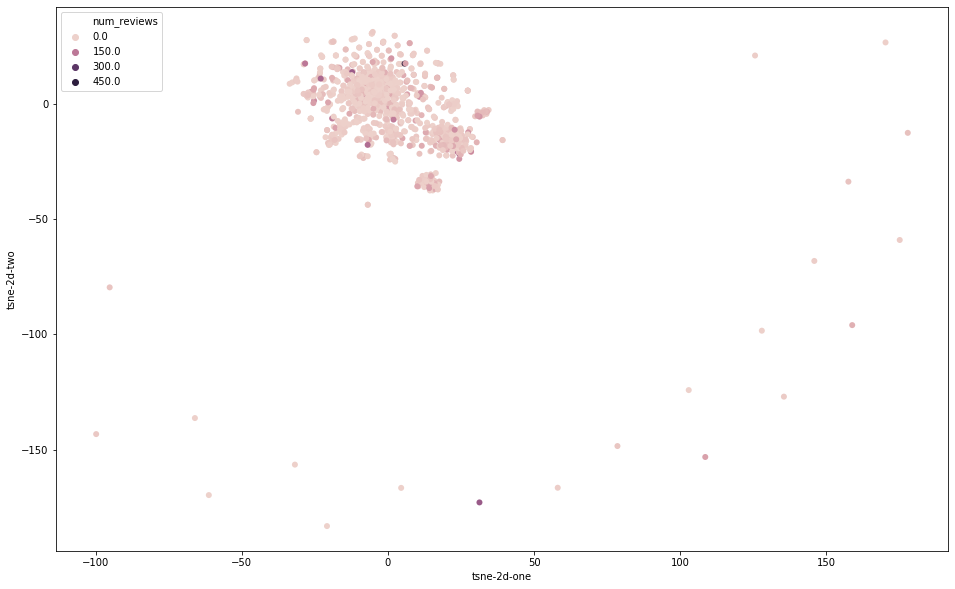

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
#recipe_df["tsne-2d-one"] = tsne_results[:, 0]
#recipe_df["tsne-2d-two"] = tsne_results[:, 1]
#tsne_1 = tsne_results[:, 0]
#epi_vec["color"] = small_vec["tags"].apply(lambda x: "Dessert" if "Dessert" in x else "Not Dessert")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=small_vec, linewidth=0)
plt.show()

In [ ]:
## Here I'm just exploring outliers in the t-SNE
#sample_df = recipe_df.loc[recipe_df["tsne-2d-two"] >= 50]
#drop_cols = sample_df.columns[(sample_df == 0).sum() == sample_df.shape[0]]
#sample_df.drop(drop_cols, axis=1, inplace=True)
#sample_df.columns.unique().values
#sample_df.head(15)

In [ ]:
#sample_df.columns.unique().values